In [2]:
### uses vgg.json file to create binary images of the ground truth fretboard segmentations

import cv2 as cv
import json
import numpy as np
import os
from matplotlib import pyplot as plt
from PIL import Image

# expects fretboard dataset to be in data folder on same level as tabs_generator folder
train_str = "test" # change to train or test to perform on respective data
dataset_path = "../data/fretboard_dataset/"
images_path = f"../data/fretboard_dataset/fretboard_frames_{train_str}/"
image_fns = os.listdir(images_path)
json_fn = os.path.join(dataset_path, f"fretboard_labels_{train_str}_vgg.json")
f = open(json_fn)
data = json.load(f) # data is dict of json contents
k = list(data.keys())

for i, fn in enumerate(image_fns):
    img_path = os.path.join(images_path, fn)
    out_path = os.path.join(images_path, "annotated_"+fn)
    img = np.asarray(Image.open(img_path)) # loads images w/ range of 0:255
    x_list = data[k[i]]["regions"]["0"]["shape_attributes"]["all_points_x"] # list of rectangle coordinates
    y_list = data[k[i]]["regions"]["0"]["shape_attributes"]["all_points_y"]
    x_list.pop(-1) # remove duplicate of first coordinate from end of lists
    y_list.pop(-1)
    poly_corners = np.asarray([list(zip(x_list, y_list))], dtype=np.int32) # repackage into np array w/ correct dtype
    new_img = np.zeros((img.shape[0], img.shape[1]), np.uint8) # create empty binary image mask
    new_img = cv.fillPoly(new_img, poly_corners, 255) # fill polygon of rectangle coordinates
    Image.fromarray(new_img).save(out_path) # save output image

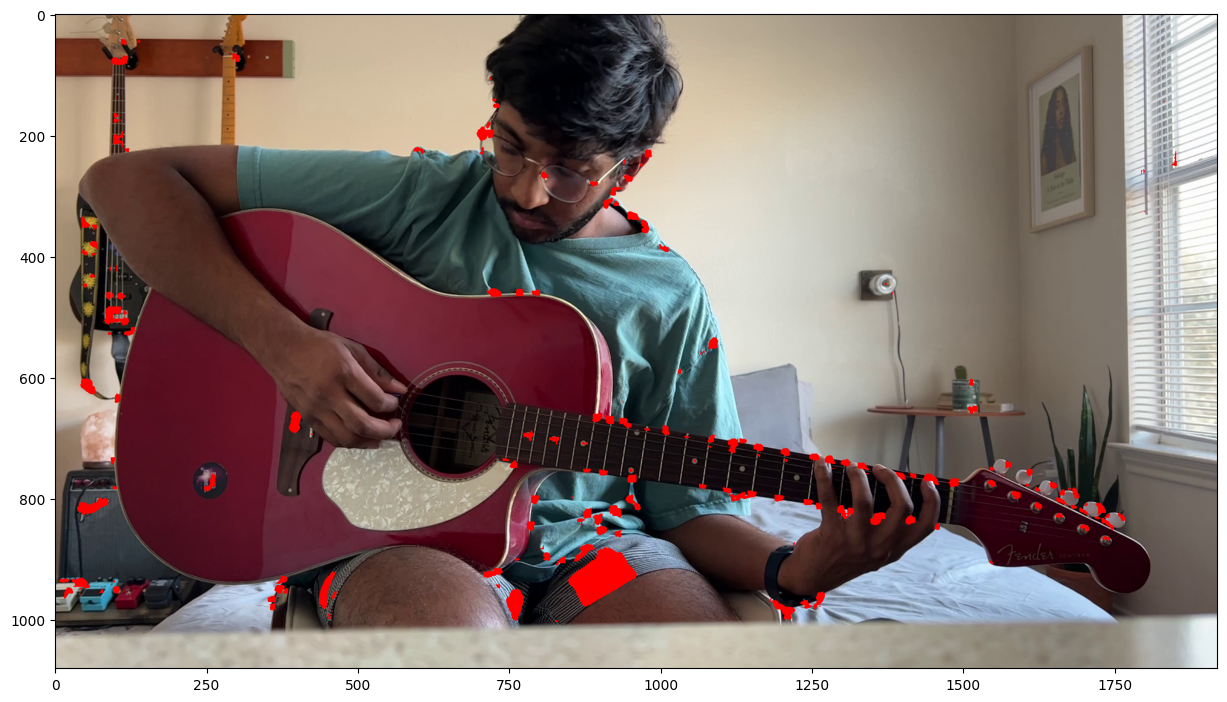

In [22]:
### loads segmentation result and identifies corner locations
%matplotlib inline
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL

dataset_path = "../data/fretboard_dataset/"
frames_path = "../data/fretboard_dataset/fretboard_frames_train/"
# segmentation_path = os.path.join(dataset_path, "segmentation_results")
frames_fn_list = os.listdir(frames_path)

frame_fn = frames_fn_list[1]
img = cv.imread(os.path.join(frames_path, frame_fn))
gray = np.float32(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
dst = cv.cornerHarris(gray, 13, 3, 0.04)
# dst = cv.dilate(dst, None)

img[dst>0.05*dst.max()] = [0,0,255]
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.show()

Idea for finding the fretboard:
1. create ideal locations of the fretboard markers
2. detect features using corner detection or blob detection
3. feed these features into a neural network to find fretboard??

In [13]:
import cv2 as cv
import json
import numpy as np
import os
from matplotlib import pyplot as plt
from PIL import Image

f = open("../data/fretboard_dataset/first10.json")
data = json.load(f)
k = list(data.keys())
x_list = data[k[0]]["regions"][0]["shape_attributes"]["all_points_x"]


[599, 911, 937, 631]
